In [1]:
from functions_combined_BEST import *

For detailed help as well as source code, use `ihelp(function)`


In [1]:
# import pandas as pd 
# import numpy as np
# import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

# def quick_table(tuples, col_names=None, caption =None,display_df=True):
#     """Accepts a bigram output tuple of tuples and makes captioned table."""
#     import pandas as pd
#     from IPython.display import display
#     if col_names == None:
    
#         df = pd.DataFrame.from_records(tuples)
        
#     else:
        
#         df = pd.DataFrame.from_records(tuples,columns=col_names)
#         dfs = df.style.set_caption(caption)
        
#         if display_df == True:
#             display(dfs)
            
#     return df

# def compare_word_cloud(text1,label1,text2,label2):
#     """Compares the wordclouds from 2 sets of texts"""
#     from wordcloud import WordCloud
#     import matplotlib.pyplot as plt

#     wordcloud1 = WordCloud(max_font_size=80, max_words=200, background_color='white').generate(' '.join(text1))
#     wordcloud2 = WordCloud(max_font_size=80, max_words=200, background_color='white').generate(' '.join(text2))


#     fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,15))
#     ax[0].imshow(wordcloud1, interpolation='bilinear')
#     ax[0].set_aspect(1.5)
#     ax[0].axis("off")
#     ax[0].set_title(label1, fontsize=20)

#     ax[1].imshow(wordcloud2, interpolation='bilinear')
#     ax[1].set_aspect(1.5)
#     ax[1].axis("off")
#     ax[1].set_title(label2, fontsize=20)

#     fig.tight_layout()
#     return fig,ax

# # Define get_tags_ats to accept a list of text entries and return all found tags and ats as 2 series/lists
# def get_tags_ats(text_to_search,exp_tag = r'(#\w*)',exp_at = r'(@\w*)', output='series',show_counts=False):
#     """Accepts a list of text entries to search, and a regex for tags, and a regex for @'s.
#     Joins all entries in the list of text and then re.findsall() for both expressions.
#     Returns a series of found_tags and a series of found_ats.'"""
#     import re
#     import pandas as pd
#     # Create a single long joined-list of strings
#     text_to_search_combined = ' '.join(text_to_search)
        
#     # print(len(text_to_search_combined), len(text_to_search_list))
#     found_tags = re.findall(exp_tag, text_to_search_combined)
#     found_ats = re.findall(exp_at, text_to_search_combined)
    
#     if output.lower() == 'series':
#         found_tags = pd.Series(found_tags, name='tags')
#         found_ats = pd.Series(found_ats, name='ats')
        
#         if show_counts==True:
#             print(f'\t{found_tags.name}:\n{found_tags.value_counts()} \n\n\t{found_ats.name}:\n{found_ats.value_counts()}')
                
#     if (output.lower() != 'series') & (show_counts==True):
#         raise Exception('output must be set to "series" in order to show_counts')
                       
#     return found_tags, found_ats


# def clean_text(series,is_tokens=False,return_tokens=False, urls=True, hashtags=True, mentions=True, remove_stopwords=True, verbose=False):
#     """Accepts a series/df['column'] and tokenizes, removes urls, hasthtags, and @s using regex before tokenizing and removing stopwrods"""
#     import pandas as pd
#     import re, nltk
#     from nltk.corpus import stopwords
    
#     series_cleaned=series.copy()
    
#     # Remove URLS
#     if urls==True:
#         urls = re.compile(r"(http[s]?://\w*\.\w*/+\w+)")
#         series_cleaned = series_cleaned.apply(lambda x: urls.sub(' ', x))
            
#         if verbose==True:
#             print('URLs removed...')
            
#     # Remove hashtags
#     if hashtags==True:
#         hashtags = re.compile(r'(\#\w*)')
#         series_cleaned = series_cleaned.apply(lambda x: hashtags.sub(' ', x))
        
#         if verbose==True:
#             print('Hashtags removed...')
    
#     # Remove mentions
#     if mentions==True:
#         mentions = re.compile(r'(\@\w*)')
#         series_cleaned = series_cleaned.apply(lambda x: mentions.sub(' ',x))

#         if verbose==True:
#             print('Mentions removed...')
    
    
#     # Regexp_tokenize stopped words (to keep contractions)
#     if is_tokens==False:
#         pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
#         series_cleaned = series_cleaned.apply(lambda x: nltk.regexp_tokenize(x,pattern))
#         if verbose==True:
#             print('Text regexp_tokenized...\n')
    
    
#     # Filter Out Stopwords
#     stopwords_list = []
#     from nltk.corpus import stopwords
#     import string
    
#     # Generate Stopwords List
#     stopwords_list = stopwords.words('english')
#     stopwords_list += list(string.punctuation)
#     stopwords_list += ['http','https','...','``','co','“','’','‘','”',
#                        'rt',"n't","''","RT",'u','s',"'s",'?']#,'@','#']
#     stopwords_list += [0,1,2,3,4,5,6,7,8,9]
#     stopwords_list +=['RT','rt',';']
     
#     if remove_stopwords==True:
#         series_cleaned = series_cleaned.apply(lambda x: [w.lower() for w in x if w.lower() not in stopwords_list])
#         # for s in range(len(series_cleaned)):
#         #     text =[]
#         #     text_stopped = []
#         #     text = series_cleaned[s]
#         #     text_stopped = [x.lower() for x in text if x.lower() not in stopwords_list]
#         #     series_cleaned[s]= text_stopped
        
#         if verbose==True:
#             print('Stopwords removed...')
       
#     if return_tokens==False:
#         series_cleaned = series_cleaned.apply(lambda x: ' '.join(x))
    
#     print('\n')
#     return series_cleaned

# def train_test_val_split(X,y,test_size=0.20,val_size=0.1):
#     """Performs 2 successive train_test_splits to produce a training, testing, and validation dataset"""
#     from sklearn.model_selection import train_test_split

#     first_split_size = test_size + val_size
#     second_split_size = val_size/(test_size + val_size)

#     X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=first_split_size)

#     X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=second_split_size)

#     return X_train, X_test, X_val, y_train, y_test, y_val


# def plot_keras_history(history):
#     """Plots the history['acc','val','val_acc','val_loss']"""
#     import matplotlib.pyplot as plt
#     acc = history.history['acc']
#     loss = history.history['loss']
#     val_acc = history.history['val_acc']
#     val_loss = history.history['val_loss']
#     x = range(1,len(acc)+1)
    
#     fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
#     ax[0].plot(x, acc,'b',label='Training Acc')
#     ax[0].plot(x, val_acc,'r',label='Validation Acc')
#     ax[0].legend()
#     ax[1].plot(x, loss,'b',label='Training Loss')
#     ax[1].plot(x, val_loss, 'r', label='Validation Loss')
#     ax[1].legend()
#     plt.show()
#     return fig, ax


# def plot_auc_roc_curve(y_test, y_test_pred):
#     """ Takes y_test and y_test_pred from a ML model and plots the AUC-ROC curve."""
#     from sklearn.metrics import confusion_matrix
#     from sklearn.metrics import roc_auc_score, roc_curve
#     import matplotlib.pyplot as plt
#     auc = roc_auc_score(y_test, y_test_pred[:,1])

#     FPr, TPr, _  = roc_curve(y_test, y_test_pred[:,1])
#     plt.plot(FPr, TPr,label=f"AUC for CatboostClassifier:\n{round(auc,2)}" )

#     plt.plot([0, 1], [0, 1],  lw=2,linestyle='--')
#     plt.xlim([-0.01, 1.0])
#     plt.ylim([0.0, 1.05])

#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic (ROC) Curve')
#     plt.legend(loc="lower right")
#     plt.show()



# def display_random_tweets(df_tokenize,n=5 ,display_cols=['content','text_for_vectors','tokens'], group_labels=[],verbose=True):
#     """Takes df_tokenize['text_for_vectors']"""
#     import numpy as np
#     import pandas as pd 
#     from IPython.display import display
#     if len(group_labels)==0:

#         group_labels = display_cols

    
#     random_tweets={}
#     # Randomly pick n indices to display from specified col
#     idx = np.random.choice(range(len(df_tokenize)), n)
    
#     for i in range(len(display_cols)):
        
#         group_name = str(group_labels[i])
#         random_tweets[group_name] ={}

#         # Select column data
#         df_col = df_tokenize[display_cols[i]]
        

#         tweet_group = {}
#         tweet_group['index'] = idx
        
#         chosen_tweets = df_col[idx]
#         tweet_group['text'] = chosen_tweets

#         # print(chosen_tweets)
#         if verbose>0:
#             with pd.option_context('max_colwidth',300):
#                 df_display = pd.DataFrame.from_dict(tweet_group)
#                 display(df_display.style.set_caption(f'Group: {group_name}'))


#         random_tweets[group_name] = tweet_group
        
#         # if verbose>0:
              
#         #     for group,data in random_tweets.items():
#         #         print(f'\n\nRandom Tweet for {group:>.{300}}:\n{"---"*20}')

#         #         df = random_tweets[group]
#         #         display(df)
#     if verbose==0:
#         return random_tweets
#     else:
#         return


# def reload(mod):
#     """Reloads the module from file."""
#     from importlib import reload
#     import sys
#     print(f'Reloading...')
#     return  reload(mod)


# def process_df_full(df_full, raw_col='content_raw', fill_content_col='content',force=False):
#     """Accepts df_full, which contains the raw tweets to process, the raw_col name, the column to fill.
#     If force=False, returns error if the fill_content_col already exists.
#     Processing Workflow:1) Create has_RT, starts_RT columns. 2) Creates [fill_content_col,`content_min_clean`] cols after removing 'RT @mention:' and urls.
#     3) Removes hashtags from fill_content_col and saves hashtags in new col. 4) Removes mentions from fill_content_col and saves to new column."""
#     import re
#     import pandas as pd
    
#     if force==False:
#         if fill_content_col in df_full.columns:
#             raise Exception(f'{fill_content_col} already exists. To overwrite, set force=True.')


#     # # create 'content_raw' column from 'content'
#     # df_full[fill_content_col] = df_full['content'].copy()


#     # Add has_RT and starts_RT columns
#     # Creating columns for tweets that `has_RT` or `starts_RT`
#     df_full['has_RT']=df_full[raw_col].str.contains('RT')
#     df_full['starts_RT']=df_full[raw_col].str.contains('^RT')


#     ## FIRST REMOVE THE RT HEADERS

#     # Remove `RT @Mentions` FIRST:
#     re_RT = re.compile(r'RT [@]?\w*:')

#     # raw_col =  'content_raw'
#     check_content_col =raw_col
#     fill_content_col = fill_content_col

#     df_full['content_starts_RT'] = df_full[check_content_col].apply(lambda x: re_RT.findall(x))
#     df_full[fill_content_col] =  df_full[check_content_col].apply(lambda x: re_RT.sub(' ',x))


#     ## SECOND REMOVE URLS
#     # Remove urls with regex
#     urls = re.compile(r"(http[s]?://\w*\.\w*/+\w+)")

#     check_content_col = fill_content_col
#     fill_content_col = fill_content_col

#     # df_full['content_urls'] = df_full[check_content_col].apply(lambda x: urls.findall(x))
#     df_full[fill_content_col] =  df_full[check_content_col].apply(lambda x: urls.sub(' ',x))

#     ## SAVE THIS MINIMALLY CLEANED CONTENT AS 'content_min_clean'
#     df_full['content_min_clean'] =  df_full[fill_content_col]




#     ## REMOVE AND SAVE HASHTAGS, MENTIONS
#     # Remove and save Hashtags
#     hashtags = re.compile(r'\#\w*')

#     check_content_col = fill_content_col
#     fill_content_col = fill_content_col

#     df_full['content_hashtags'] =  df_full[check_content_col].apply(lambda x: hashtags.findall(x))
#     df_full[fill_content_col] =  df_full[check_content_col].apply(lambda x: hashtags.sub(' ',x))


#     # Remove and save mentions (@)'s
#     mentions = re.compile(r'\@\w*')

#     check_content_col = fill_content_col
#     fill_content_col = fill_content_col

#     df_full['content_mentions'] =  df_full[check_content_col].apply(lambda x: mentions.findall(x))
#     df_full[fill_content_col] =  df_full[check_content_col].apply(lambda x: mentions.sub(' ',x))

#     return df_full



# def load_orig_dataset(root_dir = 'russian-troll-tweets/', ext='.csv'):
#     """Accepts a root_dir, finds all files that end with ext and loads into a dataframe."""
#     import os
#     import pandas as pd
#     # root_dir = 'russian-troll-tweets/'
#     # os.listdir('russian-troll-tweets/')
#     filelist = [os.path.join(root_dir,file) for file in os.listdir(root_dir) if file.endswith(ext)]
#     print(f'Loading {len(filelist)} files into dataframe...')
#         # Vertically concatenate 
#     df = pd.DataFrame()
#     for file in filelist:
#         df_new = pd.read_csv(file)
#         df = pd.concat([df,df_new], axis=0)
#     # df.info()

#     return df

# def ask_user_to_save(df, filename=None,encoding=None, ask=True, skip_saving=False, overwrite=False):
#     """Asks user to save df as filename. If no filename specified: filename ='saved_df.csv'
#     Set ask=False to save without asking."""
#     import os, warnings

#     if type(df)=='string':
#         raise Exception('First input must be the dataframe to be saved.')
#     if skip_saving==True:
#         return print(f'Since skip_loading=True, no file was save.')

#     if filename==None:
#         filename='saved_df.csv'
    
#     if ask==True:
#         ans = input('Would you like to save the df to a .csv?(y/n):')
#     else:
#         ans = 'y'
    
#     # If ans to save =='y'
#     if ans.lower()=='y':

#         # Check if the file already exists
#         if filename in os.listdir():
        
#             if overwrite==False:
#                 # raise Exception(f"{filename} already exists.")
#                 return warnings.warn(f"{filename} already exists.")

#             if overwrite==True:
#                 warnings.warn(f"Overwriting {filename}.")

#         df.to_csv(filename)
#         print(f'{filename} successfully saved.')
#     else:
#         print('Ok. No file was saved. ')
        

# def ask_user_to_load(filename, load_as_global = True ,ask=True, skip_loading=False, index_col=0, encoding=None):
#     """Asks user to save df as filename. If no filename specified: filename ='saved_df.csv'
#     Set ask=False to save without asking."""
#     import os
#     import pandas as pd

    
#     if skip_loading==True:
#         return print(f'Since skip_loading=True, no file was loaded.')
        

#     if ask==True:
#         ans = input('Would you like to load {filename} to a datafrane?(y/n):')

#     else:
#         ans = 'y'
        

#     # If ans to load =='y'
#     if ans.lower()=='y':
        
#         if load_as_global == True:
#             global df_
#             df_ = pd.read_csv(filename, encoding=encoding,index_col=index_col) 
#             print(f'{filename} loaded as global variable: "df_"')
#             pass
#         else:
#             df_ = pd.read_csv(filename, encoding=encoding,index_col=index_col) 
#             return df_
#     else:
#         return print('Ok. No file was loaded.')
        

# def run_all_checkpoint(skip=False):
#     ans = input('Continue running all?(y/n):')
#     if ans.lower()=='y':
#         return print('OK. Continuing to run...')
#     else:
#         raise Exception('User requested to stop running.')


# ## TO CHECK FOR STRINGS IN BOTH DATASETS:
# def check_dfs_for_exp_list(df_controls, df_trolls, list_of_exp_to_check):
#     df_resample = df_trolls
#     for exp in list_of_exp_to_check:
#     #     exp = '[Pp]eggy'
#         print(f'For {exp}:')
#         print(f"\tControl tweets: {len(df_controls.loc[df_controls['content_min_clean'].str.contains(exp)])}")
#         print(f"\tTroll tweets: {len(df_resample.loc[df_resample['content_min_clean'].str.contains(exp)])}\n")
              
# # list_of_exp_to_check = ['[Pp]eggy','[Mm]exico','nasty','impeachment','[mM]ueller']
# # check_dfs_for_exp_list(df_controls, df_resample, list_of_exp_to_check=list_of_exp_to_check)


# def get_group_texts_tokens(df_small, groupby_col='troll_tweet', group_dict={0:'controls',1:'trolls'}, column='content_stopped'):
#     from nltk import regexp_tokenize
#     pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
#     text_dict = {}
#     for k,v in group_dict.items():
#         group_text_temp = df_small.groupby(groupby_col).get_group(k)[column]
#         group_text_temp = ' '.join(group_text_temp)
#         group_tokens = regexp_tokenize(group_text_temp, pattern)
#         text_dict[v] = {}
#         text_dict[v]['tokens'] = group_tokens
#         text_dict[v]['text'] =  ' '.join(group_tokens)
            
#     print(f"{text_dict.keys()}:['tokens']|['text']")
#     return text_dict



# def check_df_groups_for_exp(df_full, list_of_exp_to_check, check_col='content_min_clean', groupby_col='troll_tweet', group_dict={0:'Control',1:'Troll'}):      
#     """Checks `check_col` column of input dataframe for expressions in list_of_exp_to_check and 
#     counts the # present for each group, defined by the groupby_col and groupdict. 
#     Returns a dataframe of counts."""
    
#     list_of_results = []      

#     header_list= ['Term']
#     [header_list.append(x) for x in group_dict.values()]
#     list_of_results.append(header_list)
    
#     for exp in list_of_exp_to_check:
#         curr_exp_list = [exp]
        
#         for k,v in group_dict.items():
#             df_group = df_full.groupby(groupby_col).get_group(k)
#             curr_group_count = len(df_group.loc[df_group[check_col].str.contains(exp)])
#             curr_exp_list.append(curr_group_count)
        
#         list_of_results.append(curr_exp_list)
        
#     df_results = bs.list2df(list_of_results, index_col='Term')
#     return df_results


# ###########################################################################

# def plot_fit_cloud(troll_cloud,contr_cloud,label1='Troll',label2='Control'):
#     import matplotlib.pyplot as plt
#     fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(18,18))

#     ax[0].imshow(troll_cloud, interpolation='gaussian')
#     # ax[0].set_aspect(1.5)
#     ax[0].axis("off")
#     ax[0].set_title(label1, fontsize=40)

#     ax[1].imshow(contr_cloud, interpolation='bilinear',)
#     # ax[1].set_aspect(1.5)
#     ax[1].axis("off")
#     ax[1].set_title(label2, fontsize=40)
#     plt.tight_layout()
#     return fig, ax
              
              
              

# ############### TIMESERIES TESTS AND VISUALS ###############

# def plot_time_series(stocks_df, freq=None, fill_method='ffill',figsize=(12,4)):
    
#     df = stocks_df.copy()
#     df.fillna(method=fill_method, inplace=True)
#     df.dropna(inplace=True)
    
#     if (df.index.freq==None) & (freq == None):
#         xlabels=f'Time'
    
#     elif (df.index.freq==None) & (freq != None):
#         df = df.asfreq(freq)
#         df.fillna(method=fill_method, inplace=True)
#         df.dropna(inplace=True)
#         xlabels=f'Time - Frequency = {freq}'

#     else:
#         xlabels=f'Time - Frequency = {df.index.freq}'
        
#     ylabels="Price"

#     raw_plot = df.plot(figsize=figsize)
#     raw_plot.set_title('Stock Bid Closing Price ')
#     raw_plot.set_ylabel(ylabels)
#     raw_plot.set_xlabel(xlabels)
    
    
# #################### TIMEINDEX FUNCTIONS #####################
# def get_day_window_size_from_freq(dataset):#, freq='CBH'):
    
#     if dataset.index.freq == custom_BH_freq():
#         return 7
    
#     if dataset.index.freq=='T':
#         day_window_size = 1440
#     elif dataset.index.freq=='BH':
#         day_window_size = 8
#     elif dataset.index.freq=='CBH':
#         day_window_size = 7
#     elif dataset.index.freq=='B':
#         day_window_size=1
#     elif dataset.index.freq=='D':
#         day_window_size=1
        
#     else:
#         raise Exception('dataset freq=None')
        
#     return day_window_size
    

# def custom_BH_freq():
#     import pandas as pd
#     CBH = pd.tseries.offsets.CustomBusinessHour(start='09:30',end='16:30')
#     return CBH
    
    
# def  set_timeindex_freq(ive_df, col_to_fill=None, freq='CBH',fill_method='ffill',
#                         verbose=3): #set_tz=True,
    
#     import pandas as pd
#     import numpy as np
    
    
#     if verbose>1:
#         # print(f"{'Index When:':>{10}}\t{'Freq:':>{20}}\t{'Index Start:':>{40}}\t{'Index End:':>{40}}")
#         print(f"{'Index When:'}\t{'Freq:'}\t{'Index Start'}\t\t{'Index End:'}")
#         print(f"Pre-Change\t{ive_df.index.freq}\t{ive_df.index[0]}\t{ive_df.index[-1]}")
        
    
#     if freq=='CBH':
#         freq=custom_BH_freq()
# #         start_idx = 
        
#     # Change frequency to freq
#     ive_df = ive_df.asfreq(freq,)#'min')
    
#     #     # Set timezone
#     #     if set_tz==True:
#     #         ive_df.tz_localize()
#     #         ive_df.index = ive_df.index.tz_convert('America/New_York')
    
#     # Report Success / Details
#     if verbose>1:
#         print(f"Post-Change\t{ive_df.index.freq}\t{ive_df.index[0]}\t{ive_df.index[-1]}")


#     ## FILL AND TRACK TIMEPOINTS WITH MISSING DATA    
    
#     # Helper Function for adding column to track the datapoints that were filled
#     def check_null_times(x):
#         import numpy as np
#         if np.isnan(x):
#             return True
#         else:
#             return False

#     ## CREATE A COLUMN TO TRACK ROWS TO BE FILLED
#     # If col_to_fill provided, use that column to create/judge ive_df['filled_timebin'] 
#     if col_to_fill!=None:
#         ive_df['filled_timebin'] = ive_df[col_to_fill].apply(lambda x: check_null_times(x))#True if ive_df.isna().any()
        
#     # if not provided, use all columns and sum results
#     elif col_to_fill == None:
#         # Prefill fol with 0's
#         ive_df['filled_timebin']=0
        
#         # loop through all columns and add results of check_null_times from each loop
#     for col in ive_df.columns:
#         if ive_df[col].dtypes=='float64':
#             #ive_df['filled_timebin'] = ive_df[target_col].apply(lambda x: check_null_times(x))#True if ive_df.isna().any()
#             curr_filled_timebin_col = ive_df[col].apply(lambda x: check_null_times(x))#True if ive_df.isna().any() 

#             # add results
#             ive_df['filled_timebin'] +=  curr_filled_timebin_col
            
#     ive_df['filled_timebin'] = ive_df['filled_timebin'] >0
            
#     ## FILL IN NULL VALUES
#     ive_df.fillna(method=fill_method, inplace=True)

#     # Report # filled
#     if verbose>0:
#         check_fill = ive_df.loc[ive_df['filled_timebin']>0]
#         print(f'\nFilled {len(check_fill==True)}# of rows using method {fill_method}')
    
#     # Report any remaning null values
#     if verbose>0:
#         res = ive_df.isna().sum()
#         if res.any():
#             print(f'Cols with Nulls:')
#             print(res[res>0])
#         else:
#             print('No Remaining Null Values')   
            
#     # display header
#     if verbose>2:
#         display(ive_df.head())
    
#     return ive_df


# # Helper Function for adding column to track the datapoints that were filled
# def check_null_times(x):
#     import numpy as np
#     if np.isnan(x):
#         return True
#     else:
#         return False
              
# ######## SEASONAL DECOMPOSITION    
# def plot_decomposition(TS, decomposition, figsize=(12,8),window_used=None):
#     """ Plot the original data and output decomposed components"""
    
#     # Gather the trend, seasonality and noise of decomposed object
#     trend = decomposition.trend
#     seasonal = decomposition.seasonal
#     residual = decomposition.resid

#     fontdict_axlabels = {'fontsize':12}#,'fontweight':'bold'}
    
#     # Plot gathered statistics
#     fig, ax = plt.subplots(nrows=4, ncols=1,figsize=figsize)
    
#     ylabel = 'Original'
#     ax[0].plot(np.log(TS), color="blue")
#     ax[0].set_ylabel(ylabel, fontdict=fontdict_axlabels)
    
#     ylabel = label='Trend'
#     ax[1].plot(trend, color="blue")
#     ax[1].set_ylabel(ylabel, fontdict=fontdict_axlabels)
    
#     ylabel='Seasonality'
#     ax[2].plot(seasonal, color="blue")
#     ax[2].set_ylabel(ylabel, fontdict=fontdict_axlabels)
    
#     ylabel='Residuals'
#     ax[3].plot(residual, color="blue")
#     ax[3].set_ylabel(ylabel, fontdict=fontdict_axlabels)
#     ax[3].set_xlabel('Time', fontdict=fontdict_axlabels)
    
#     # Add title with window 
#     if window_used == None:
#         plt.suptitle('Seasonal Decomposition', y=1.02)
#     else:
#         plt.suptitle(f'Seasonal Decomposition - Window={window_used}', y=1.02)
    
#     # Adjust aesthetics
#     plt.tight_layout()
    
#     return ax
    
    
# def seasonal_decompose_and_plot(ive_df,col='BidClose',freq='H',
#                           fill_method='ffill',window=144,
#                          model='multiplicative', two_sided=False,
#                                plot_components=True):##WIP:
#     """Perform seasonal_decompose from statsmodels.tsa.seasonal.
#     Plot Output Decomposed Components"""
#     import pandas as pd
#     import numpy as np
#     from statsmodels.tsa.seasonal import seasonal_decompose


#     # TS = ive_df['BidClose'].asfreq('BH')
#     TS = pd.DataFrame(ive_df[col])
#     TS = TS.asfreq(freq)
#     TS[TS==0]=np.nan
#     TS.fillna(method='ffill',inplace=True)

#     # Perform decomposition
#     decomposition = seasonal_decompose(np.log(TS),freq=window, model=model, two_sided=two_sided)
    
#     if plot_components==True:
#         ax = plot_decomposition(TS, decomposition, window_used=window)
    
#     return decomposition



# def stationarity_check(df, col='BidClose',freq=None, day_window_size='infer',
#                        days_in_rolling_window=5):
#     """From learn.co lesson: use ADFuller Test for Stationary and Plot"""
    
#     import matplotlib.pyplot as plt
#     TS = df[col].copy()
    
#     if freq==None:
#         freq=df.index.freq
        
#     else:        
#         TS = TS.asfreq(freq)
#         TS.fillna(method='ffill',inplace=True)
#         TS.dropna(inplace=True)
    
    
#     # Import adfuller
#     from statsmodels.tsa.stattools import adfuller
#     import pandas as pd
#     import numpy as np
    
#     # Calculate rolling statistics
#     if day_window_size=='infer':
#         day_window_size = get_day_window_size_from_freq(TS)
        
#     window = day_window_size*days_in_rolling_window
#     rolmean = TS.rolling(window = window, center = False).mean()
#     rolstd = TS.rolling(window = window, center = False).std()
    
#     # Perform the Dickey Fuller Test
#     dftest = adfuller(TS) # change the passengers column as required 
    
#     #Plot rolling statistics:
#     fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,4))
#     ax[0].set_title('Rolling Mean & Standard Deviation')

#     ax[0].plot(TS, color='blue',label='Original')
#     ax[0].plot(rolmean, color='red', label='Rolling Mean',alpha =0.6)
#     ax[1].plot(rolstd, color='black', label = 'Rolling Std')
#     ax[0].legend()
#     ax[1].legend()
# #     plt.show(block=False)
#     plt.tight_layout()
    
#     # Print Dickey-Fuller test results
#     print ('Results of Dickey-Fuller Test:')
#     print('\tIf p<.05 then timeseries IS stationary.')

#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
    
#     return None
              
              
# ##################### DATASET LOADING FUNCTIONS #####################   
# def load_raw_stock_data_from_txt(filename='IVE_bidask1min.txt', 
#                                folderpath='data/',
#                                start_index = '2017-01-23',
#                                  clean=False,fill_method='ffill',
#                                  freq='CBH',verbose=2):
#     import pandas as pd
    
#     # Load in the text file and set headers
#     fullfilename= folderpath+filename
#     headers = ['Date','Time','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose']
#     stock_df = pd.read_csv(fullfilename, names=headers,parse_dates=True)
    
#     # Create datetime index
#     date_time_index = stock_df['Date']+' '+stock_df['Time']
#     date_time_index = pd.to_datetime(date_time_index)
#     stock_df.index=date_time_index
    
#     # Select only the days after start_index
#     stock_df = stock_df[start_index:]
    
#     # Remove 0's from BidClose
#     if clean==True:
        
#         stock_df.loc[stock_df['BidClose']==0] = np.nan
#         stock_df['BidClose'].fillna(method=fill_method, inplace=True)
        
#         if verbose>0:
#             print(f"Number of 0 values:\n{len(stock_df.loc[stock_df['BidClose']==0])}")
#             print(f"Filling 0 values using method = {fill_method}")
            


                  
#     # call set_timeindex_freq to specify proper frequency
#     if freq!=None:
#         # Set the time index .
#         stock_df = set_timeindex_freq(stock_df, freq=freq, fill_method = fill_method, verbose=verbose)
                  
#     # Display feedback
#     if verbose>0:
#         display(stock_df.head())
#     if verbose>1:
#         print(stock_df.index)

#     return stock_df



# # def load_stock_df_from_csv(filename='ive_sp500_min_data_match_twitter_ts.csv',
# #                            folderpath='data/',
# #                           start_index = '2017-01-23', clean=False,freq='CBH',
# #                            fill_method='ffill',verbose=2):
# #     import os
# #     import pandas as pd

# #     #         check_for_google_drive()
        
# #     # Check if user provided folderpath to append to filename
# #     if len(folderpath)>0:
# #         fullfilename = folderpath+filename
# #     else:
# #         fullfilename=filename
        
# #     # load in csv by fullfilename
# #     stock_df = pd.read_csv(fullfilename,index_col=0, parse_dates=True)
# #     stock_df = stock_df[start_index:]
# # #     stock_df = set_timeindex_freq(stock_df,['BidClose'],freq=freq, fill_method=fill_method)
    
# #     if clean==True:
        
# #         if verbose>0:
# #             print(f"Number of 0 values:\n{len(stock_df.loc[stock_df['BidClose']==0])}")
# #             print(f"Filling 0 values using method = {fill_method}")
            
# #         stock_df.loc[stock_df['BidClose']==0] = np.nan
# #         stock_df['BidClose'].fillna(method=fill_method, inplace=True)
        
# #     if freq!=None:
# #         # Set the time index .
# #         stock_df = set_timeindex_freq(stock_df, freq=freq, fill_method = fill_method, verbose=verbose)
        

# #     # Display info depending on verbose level
# #     if verbose>0:
# #         display(stock_df.head())
    
# #     if verbose>1:
# #         print(stock_df.index)
        
# #     return stock_df   
                  
# def get_technical_indicators(dataset,make_price_from='BidClose'):
    

#     dataset['price'] = dataset[make_price_from].copy()
#     if dataset.index.freq == custom_BH_freq():
#         days = get_day_window_size_from_freq(dataset)#,freq='CBH')
#     else:
#         days = get_day_window_size_from_freq(dataset)
        
#     # Create 7 and 21 days Moving Average
#     dataset['ma7'] = dataset['price'].rolling(window=7*days).mean()
#     dataset['ma21'] = dataset['price'].rolling(window=21*days).mean()
    
#     # Create MACD
#     dataset['26ema'] = dataset['price'].ewm(span=26*days).mean()
# #     dataset['12ema'] = pd.ewma(dataset['price'], span=12)
#     dataset['12ema'] = dataset['price'].ewm(span=12*days).mean()

#     dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

#     # Create Bollinger Bands
# #     dataset['20sd'] = pd.stats.moments.rolling_std(dataset['price'],20)
#     dataset['20sd'] = dataset['price'].rolling(20*days).std()
#     dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
#     dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
#     # Create Exponential moving average
#     dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
#     # Create Momentum
#     dataset['momentum'] = dataset['price']-days*1
    
#     return dataset

                  
# def plot_technical_indicators(dataset, last_days=90):
   
#     days = get_day_window_size_from_freq(dataset)
    
#     fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(10, 6), dpi=100)
# #     shape_0 = dataset.shape[0]
# #     xmacd_ = shape_0-(days*last_days)
    
#     dataset = dataset.iloc[-(days*last_days):, :]
#     x_ = range(3, dataset.shape[0])
#     x_ =list(dataset.index)
    
#     # Plot first subplot
#     ax[0].plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
#     ax[0].plot(dataset['price'],label='Closing Price', color='b')
#     ax[0].plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
#     ax[0].plot(dataset['upper_band'],label='Upper Band', color='c')
#     ax[0].plot(dataset['lower_band'],label='Lower Band', color='c')
#     ax[0].fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
#     ax[0].set_title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
#     ax[0].set_ylabel('USD')
#     ax[0].legend()

# #     shape_0 = dataset.shape[0]
# #     xmacd_ = shape_0-(days*last_days)
# #     # Plot second subplot
# #     ax[1].set_title('MACD')
# #     ax[1].plot(dataset['MACD'],label='MACD', linestyle='-.')
# #     ax[1].hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
# #     ax[1].hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
# #     ax[1].plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

# #     ax[1].legend()
#     plt.delaxes(ax[1])
#     plt.show()
    
# # plot_technical_indicators(stock_df)#.filter(regex='Bid'))  


In [3]:
# def train_test_split_by_last_days(stock_df, periods_per_day=7,num_test_days = 90, num_train_days=180, plot=True):
#     """Takes the last num_test_days of the time index to use as testing data, and take shte num_Trian_days prior to that date
#     as the training data."""
#     # DETERMINING DAY TO USE TO SPLIT DATA INTO TRAIN AND TEST
#     day_freq = periods_per_day
#     start_train_day = stock_df.index[-1] - num_train_days*day_freq
#     last_day = stock_df.index[-1] - num_test_days*day_freq
#     print(f'Dates for Train Data:{start_train_day} : {last_day}.')
#     print(f'Dates for Test Data:{last_day} : {stock_df.index[-1]}.')
#     train_data = stock_df.loc[start_train_day:last_day]#,'price']
#     test_data = stock_df.loc[last_day:]#,'price']
#     print(f'Data split on index:{last_day}.')
#     print(f'train_data.shape:{train_data.shape}')
#     print(f'test_data.shape:{test_data.shape}')


#     if plot==True:
#         if 'price' in stock_df.columns:
#             plot_col ='price'
#         elif 'price_labels' in stock_df.columns:
#             plot_col = 'price_labels'
        
#         train_data[plot_col].plot(label='Training')
#         test_data[plot_col].plot(label='Test')
#         plt.title('Training and Test Data for S&P500')
#         plt.ylabel('Price')
#         plt.xlabel('Trading Date/Hour')
#         plt.legend();
    
#     return train_data, test_data

# # train_data, test_data = train_test_split_by_last_days(stock_df)

In [50]:
# # display(stock_df.head())
# # df_stock_sca, scaler_library = make_scaler_library(stock_df,transform=True)
# # display(df_stock_sca.head())

# # df_stock_inv = transform_cols_from_library(df_stock_sca,scaler_library,inverse=True)
# # display(df_stock_inv.head())

# def make_X_y_timeseries_data(data,x_window = 35, verbose=2,as_array=True):
#     """Takes a Series and creates X_train, y_train where each element of X contains x_window # of timepoints
#     and y_train contains one single timepoint following X_train's timepoint"""
#     import numpy as np
#     import pandas as pd
                          
    
#     if any(data.isna()):
#         raise Exception('Function does not accept null values')
        
#     # Display info on data
#     if verbose>0:
#         print(f'Input Range: {np.min(data)} - {np.max(data)}')
#         print(f'Input Shape: {np.shape(data)}\n')

#     time_index_in = data.index
#     time_index = data.index[x_window:]
    
#     X_train, y_train = [], []
#     check_time_index = []
# #     headers = data.columns
#     # for every possible x_window:
#     for i in range(x_window, data.shape[0]):
#         check_time_index.append([data.index[i-x_window], data.index[i]])
#         # Append a list of the past x_window # of timepoints
#         X_train.append(data.iloc[i-x_window:i])#.values)
        
#         # Append the next single timepoint's data
#         y_train.append(data.iloc[i])#.values)
    
#     if as_array == True:
#         # Make X_train, y_train into arrays
#         X_train, y_train = np.array(X_train), np.array(y_train)
    

#     if verbose>0:
#         print(f'\nOutput Shape - X: {X_train.shape}')
#         print(f'Output Shape - y: {y_train.shape}')
#         print(f'\nTimeindex Shape: {np.shape(time_index)}\n\tRange: {time_index[0]}-{time_index[-1]}')
#         print(f'\tFrequency:',time_index.freq)
# #     print(time_index)
# #     print(check_time_index)
#     return X_train, y_train, time_index


# def make_df_timeseries_bins_by_column(df, x_window = 35, verbose=2,one_or_two_dfs = 1): #target_col='price',
#     """ Function will take each column from the dataframe and create a train_data dataset  (with X and Y data), with
#     each row in X containing x_window number of observations and y containing the next following observation"""

#     col_data  = {}
#     time_index_for_df = []
#     for col in df.columns:
        
#         col_data[col] = {}
#         col_bins, col_labels, col_idx =  make_X_y_timeseries_data(df[col], verbose=0, as_array=True)#,axis=0)
# #         print(f'col_bins dtype={type(col_bins)}')
# #         print(f'col_labels dtype={type(col_labels)}')
        
#         ## ALTERNATIVE IS TO PLACE DF COLUMNS CREATION ABOVE HERE
#         col_data[col]['bins']=col_bins
#         col_data[col]['labels'] = col_labels
# #         col_data[col]['index'] = col_idx
#         time_index_for_df = col_idx
    
#     # Convert the dictionaries into a dataframe
#     df_timeseries_bins = pd.DataFrame(index=time_index_for_df)
# #     df_timeseries_bins.index=time_index_for_df
# #     print(time_index_for_df)
#     # for each original column
#     for colname,data_dict in col_data.items():
        
#         #for column's new data bins,labels
#         for data_col, X in col_data[colname].items():
            
#             # new column title
#             new_colname = colname+'_'+data_col
# #             print(new_colname)
#             make_col = []
#             if data_col=='labels':
#                 df_timeseries_bins[new_colname] = col_data[colname][data_col]
#             else:
#                 # turn array of lists into list of arrays
#                 for x in range(X.shape[0]):
#                     x_data = np.array(X[x])
# #                     x_data = X[x]
#                     make_col.append(x_data)
#                 # fill in column's data
#                 df_timeseries_bins[new_colname] = make_col
                
# #     print(df_timeseries_bins.index)
# #     print(time_index_for_df)
        
    
#     if one_or_two_dfs==1:
#         return df_timeseries_bins
    
#     elif one_or_two_dfs==2:
#         df_bins = df_timeseries_bins.filter(regex=('bins'))
#         df_labels = df_timeseries_bins.filter(regex=('labels'))
        
#     return df_bins, df_labels

In [144]:
# def make_scaler_library(df,transform=False,columns=[]):
#     from sklearn.preprocessing import MinMaxScaler
#     scaler_dict = {}
#     scaler_dict['index'] = df.index
#     if len(columns)==0:
#         user_cols = []
#         columns = df.columns
#     for col in columns:
#         user_cols=columns
#         scaler = MinMaxScaler()
#         scaler.fit(df[col].values.reshape(-1,1))
#         scaler_dict[col] = scaler 
        
#     if transform==False:
#         return scaler_dict
    
#     elif transform==True:
#         df_out = transform_cols_from_library(df, scaler_dict,columns=user_cols)
#         return df_out, scaler_dict
    
# def transform_cols_from_library(df,scaler_library,inverse=False,columns=[]):
    
#     df_out = df.copy()
    
#     if len(columns)==0:
#         columns = df.columns
#     for col in columns:
#         scaler = scaler_library[col]
#         if inverse==False:
#             scaled_col = scaler.transform(df[col].values.reshape(-1,1))
#         elif inverse==True:
#             scaled_col = scaler.inverse_transform(df[col].values.reshape(-1,1))
#         df_out[col] = scaled_col.ravel()
#     return df_out

# def inverse_transform_series(df, scaler_library,columns=[] ,scaler_colname='price'):
#     train_price_index = df.index
# #     train_price = scaler_library['price'].inverse_transform(df_train_bins['price_labels'].values.reshape(-1,1))
#     scaler = scaler_library[scaler_colname]
    
#     if len(columns)==0:
#         columns = df.columns
        
#     for col in columns:
#         if 'bins' in col:
#             print('skipping binned column: ',col)
#         else:
#             price_to_change = df[col].values
#             price_tf = scaler.inverse_transform(price_to_change.reshape(-1,1))
#             df[col]  = pd.Series(price_tf.ravel(), index=train_price_index)
#     return df


# df_train_bins_plot = inverse_transform_series(df_train_bins, scaler_library)
# # plot_me.plot()

skipping binned column:  price_bins
skipping binned column:  ma7_bins
skipping binned column:  ma21_bins
skipping binned column:  26ema_bins
skipping binned column:  12ema_bins
skipping binned column:  MACD_bins
skipping binned column:  20sd_bins
skipping binned column:  upper_band_bins
skipping binned column:  lower_band_bins
skipping binned column:  ema_bins
skipping binned column:  momentum_bins


# Trying PipeLine NLP + Param Grid

In [1]:
from functions_combined_BEST import *

For detailed help as well as source code, use `ihelp(function)`


In [4]:
ihelp(load_twitter_df)

------------------------------------------------------------------------------------------------------------------------
--------- 	HELP:	 ------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Help on function load_twitter_df in module functions_combined_BEST:

load_twitter_df(overwrite=True, set_index='time_index', verbose=2, replace_na='')

------------------------------------------------------------------------------------------------------------------------
--------- 	SOURCE:	 ------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
def load_twitter_df(overwrite=True,set_index='time_index',verbose=2,replace_na=''):
    import pandas as pd
    from IPython.display import disp

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_combined_BEST import *
def make_my_data():
    from functions_combined_BEST import full_twitter_df_processing, load_raw_twitter_file
    df = load_raw_twitter_file()
#     file = '../trump_tweets_01202017_06202019.csv'
#     df = pd.read_csv(file, encoding='utf-8')
#     df.rename(axis=1,mapper={'text':'content','created_at':'date'},inplace=True)
#     df['date']=pd.to_datetime(df['date'])
# #     df.head()

    df = full_twitter_df_processing(df,'content','final_content',force=True)
    return df
    
make_my_data()
df.head()

ImportError: cannot import name 'load_raw_twitter_file'

In [ ]:

    """Performs all text processing done in other notebook as part of NLP"""
    pass

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

X_train, y_train, X_test, y_test = make_my_data()

# PREPARING THE DATA

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
2017-02-20 15:30:00,99.64,99.0808,97.6303,98.1047,98.6017,0.496972,1.13258,99.8954,95.3651,99.64,92.64
2017-02-21 09:30:00,99.88,99.1218,97.6551,98.1289,98.6327,0.503812,1.14007,99.9353,95.375,99.8,92.88
2017-02-21 10:30:00,100.37,99.172,97.6848,98.1593,98.6748,0.515495,1.15543,99.9957,95.374,100.18,93.37
2017-02-21 11:30:00,100.15,99.2171,97.7135,98.1862,98.7105,0.524271,1.16772,100.049,95.378,100.16,93.15
2017-02-21 12:30:00,100.3,99.2627,97.7438,98.2148,98.749,0.534197,1.1815,100.107,95.3808,100.253,93.3


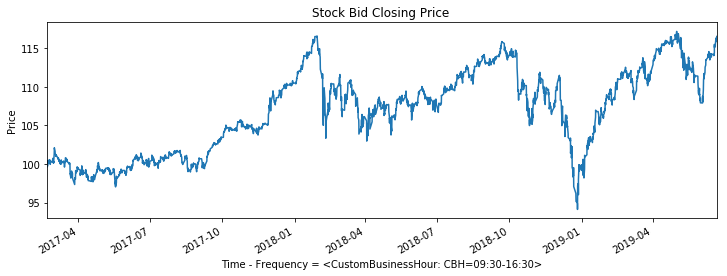

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

stock_df = pd.read_csv('data/stock_df_with_tech_indicators.csv', index_col=0, parse_dates=True)
stock_df = set_timeindex_freq(stock_df,verbose=0)
stock_df = stock_df.iloc[:,11:]

# DIsply input stock data
display(stock_df.head().style.set_caption('Raw Data'))
plot_time_series(stock_df['price'])

In [176]:
# scale the data using MinMaxScaler
stock_df_orig = stock_df.copy()
stock_df, scaler_library = make_scaler_library(stock_df_orig,transform=True)
display(stock_df.head(2).style.set_caption('MinMaxScaled'))


# Create binned columns with x_window # of sequential values, label column with next value in sequence
stock_df_binned = make_df_timeseries_bins_by_column(stock_df, x_window=35, verbose=0)#.iloc[:,11:])
# display(stock_df_binned.head(2).style.set_caption('Binned for Neural Network'))

# Split the training and test data by number of days
df_train_bins, df_test_bins = train_test_split_by_last_days(stock_df_binned,periods_per_day=7,
                                                            num_test_days=90,num_train_days=180,
                                                            plot=False)
display(df_train_bins.head(2).style.set_caption('Training Data Binned for Neural Network'))
# display(df_test_bins.head(2))

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
2017-02-20 15:30:00,0.239601,0.103854,0,0,0.0133655,0.753925,0.169668,0.0107456,0.0936182,0.230517,0.239601
2017-02-21 09:30:00,0.25,0.105984,0.00136882,0.00141256,0.0151125,0.75528,0.171286,0.0127008,0.0940857,0.237541,0.25


Dates for Train Data:2018-10-12 15:30:00 : 2019-02-15 15:30:00.
Dates for Test Data:2019-02-15 15:30:00 : 2019-06-21 15:30:00.
Data split on index:2019-02-15 15:30:00.
train_data.shape:(631, 22)
test_data.shape:(631, 22)


,price_bins,price_labels,ma7_bins,ma7_labels,ma21_bins,ma21_labels,26ema_bins,26ema_labels,12ema_bins,12ema_labels,MACD_bins,MACD_labels,20sd_bins,20sd_labels,upper_band_bins,upper_band_labels,lower_band_bins,lower_band_labels,ema_bins,ema_labels,momentum_bins,momentum_labels
2018-10-12 15:30:00,[0.86221837 0.85615251 0.87131716 0.87088388 0.87131716 0.87088388 0.89211438 0.89471404 0.8830156 0.8882149 0.88691508 0.88518198 0.88171577 0.88734835 0.87608319 0.87824957 0.86265165 0.84358752 0.83665511 0.83362218 0.81629116 0.79722704 0.73310225 0.72183709 0.68327556 0.7127383 0.69714038 0.66551127 0.66247834 0.66984402 0.64558059 0.65294627 0.62478336 0.61395147 0.61785095],0.650347,[0.89244679 0.89241499 0.89245739 0.89237259 0.8921394 0.89189562 0.89249979 0.89342195 0.8944819 0.89527686 0.89591283 0.8965064 0.89703638 0.89773595 0.89835072 0.89846731 0.89791614 0.89705758 0.89616722 0.89520266 0.89373993 0.89210761 0.88878996 0.88528152 0.88072373 0.87664292 0.87211693 0.86670059 0.86141143 0.85586789 0.84970957 0.84369965 0.83689477 0.82987789 0.82298821],0.81736,[0.91770203 0.91808455 0.91859833 0.91895835 0.91944962 0.91993715 0.92055218 0.92117471 0.92159098 0.921951 0.92231852 0.92276479 0.92316231 0.92357483 0.9239236 0.92445613 0.92476364 0.9248349 0.92484615 0.92474864 0.92452738 0.92415611 0.92325607 0.92222101 0.92073219 0.91961838 0.91835082 0.91682824 0.9152194 0.91364432 0.91183298 0.9101904 0.9082103 0.90614769 0.90411134],0.902349,[0.93034909 0.93025896 0.93039354 0.93052026 0.93065199 0.93077588 0.93121164 0.931681 0.93197263 0.93233778 0.93267977 0.93299245 0.93325057 0.93358897 0.93375748 0.9339561 0.93392243 0.93360787 0.93319447 0.93274084 0.93203647 0.93105855 0.92914525 0.92708666 0.92448166 0.9223398 0.91999123 0.91720169 0.91439789 0.9117334 0.90874006 0.9058881 0.90265182 0.8992911 0.89602463],0.893273,[0.90137748 0.90073502 0.90057191 0.90039938 0.90024417 0.90007935 0.90056835 0.90112543 0.90131126 0.9016519 0.90194473 0.90217761 0.90229889 0.90258976 0.90252892 0.90253583 0.90206507 0.90102177 0.8997908 0.89849594 0.89670098 0.89436464 0.89012019 0.88563075 0.88006644 0.87553501 0.8706327 0.86487746 0.85916478 0.85381202 0.84784241 0.84223875 0.83590478 0.82938825 0.82314442],0.818042,[0.72348875 0.72153595 0.72050676 0.71947107 0.71847931 0.7174803 0.71772285 0.71809089 0.71775614 0.71771642 0.71758715 0.71734646 0.71689836 0.71677434 0.71598967 0.71534111 0.71380054 0.71119914 0.70827292 0.70525844 0.7013356 0.69643661 0.68799963 0.67919372 0.66846088 0.65978948 0.65051475 0.63973597 0.62915511 0.61936732 0.60852545 0.59849089 0.58719136 0.57567169 0.56479122],0.556179,[0.06567584 0.06483363 0.06426881 0.06361126 0.06240198 0.06129437 0.06047332 0.05946242 0.05690104 0.05511373 0.05380544 0.05244247 0.0515674 0.0505432 0.04937702 0.04798623 0.0470807 0.04762544 0.0479184 0.04853419 0.05041888 0.05457769 0.06822887 0.08260581 0.10222495 0.11510886 0.1293626 0.1475163 0.16459317 0.17921979 0.1963459 0.21132231 0.22914572 0.2472356 0.26365052],0.27535,[0.78085294 0.78081046 0.7810111 0.7810326 0.78091998 0.78085028 0.78102453 0.78111908 0.78032446 0.77983192 0.77956401 0.77934138 0.77929731 0.77919875 0.7789788 0.77882034 0.77868224 0.77899356 0.77913688 0.77933021 0.77999065 0.78155218 0.78696169 0.79258116 0.80018161 0.80505161 0.81040792 0.81731154 0.82364838 0.82890043 0.8350793 0.84043038 0.84677619 0.85316975 0.8588246 ],0.862578,[0.93024616 0.93094655 0.93163795 0.93223765 0.93319335 0.93410106 0.93499251 0.93597399 0.93746025 0.93855728 0.93944991 0.94043448 0.94116226 0.94196861 0.94278253 0.94385367 0.9445173 0.94433891 0.94421964 0.94386454 0.94284422 0.94069355 0.93390862 0.92668788 0.91676844 0.91013706 0.90277017 0.89346674 0.884563 0.87676697 0.86766703 0.85965884 0.85010653 0.84036581 0.83138504],0.824716,[0.86071816 0.85695255 0.86593829 0.86864094 0.86983442 0.86993965 0.88431204 0.89085843 0.88514041 0.88674558 0.88640284 0.8851182 0.8823492 0.88522998 0.87858268 0.87782991 0.8670

In [148]:
# Creating X,y and index for training data and test data
index_train =df_train_bins.index
X_train = df_train_bins['price_bins'].values
y_train = df_train_bins['price_labels'].values

index_test = df_test_bins.index
X_test = df_test_bins['price_bins'].values
y_test = df_test_bins['price_labels'].values


# Converting all X and y into 2D arrays
X_train_stack =  np.vstack(X_train)
X_train_in = np.reshape(X_train_stack,(X_train_stack.shape[0],X_train_stack.shape[1],1))

X_test_stack =  np.vstack(X_test)
X_test_in = np.reshape(X_test_stack,(X_test_stack.shape[0],X_test_stack.shape[1],1))

# Displaying shapes of input
print(X_train_stack.shape, y_train.shape)

(631, 35) (631,)


In [151]:
from keras import models, layers
model = models.Sequential()

model.add(layers.LSTM(units=50, return_sequences=True, input_shape = (X_train_in.shape[1],1)))
model.add(layers.LSTM(units=50))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 35, 50)            10400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [177]:
history = model.fit(X_train_in,y_train, epochs=10, verbose=1)

# Get predictions and combine with true price
predictions = model.predict(X_test_in)
predictions = pd.Series(predictions.ravel(),name='predicted_price',index=index_test)
true_price =  pd.Series(y_test,name='true_price',index=index_test)

df_predictions = pd.concat([predictions,true_price],axis=1)#, columns=['predicted_price','true_price'], index=index_test)
display(df_predictions.head())

# Plot outcome
mpl.rcParams['figure.figsize']=(12,4)
plt.plot(df_train_bins['price_labels'])
plt.plot(df_predictions)

Epoch 1/10
 - 1s - loss: 0.0016 - acc: 0.0016
Epoch 2/10
 - 1s - loss: 0.0016 - acc: 0.0016
Epoch 3/10
 - 1s - loss: 0.0016 - acc: 0.0016
Epoch 4/10
 - 1s - loss: 0.0015 - acc: 0.0016
Epoch 5/10
 - 1s - loss: 0.0014 - acc: 0.0016
Epoch 6/10
 - 1s - loss: 0.0015 - acc: 0.0016
Epoch 7/10
 - 1s - loss: 0.0015 - acc: 0.0016
Epoch 8/10
 - 1s - loss: 0.0014 - acc: 0.0016
Epoch 9/10
 - 1s - loss: 0.0013 - acc: 0.0016
Epoch 10/10
 - 1s - loss: 0.0013 - acc: 0.0016


,predicted_price,true_price
2019-02-15 15:30:00,0.712098,0.731369
2019-02-18 09:30:00,0.715725,0.731369
2019-02-18 10:30:00,0.718753,0.731369
2019-02-18 11:30:00,0.721141,0.731369
2019-02-18 12:30:00,0.722911,0.731369


In [179]:
# df_predictions = pd.concat([df_predictions, pd.Series(y_test,name='price',index=index_test)],axis=1)
# display(df_predictions.head())
# df_predictions.index

In [180]:
# df_train_bins_plot = inverse_transform_series(df_train_bins, scaler_library)

# price_predictions = inverse_transform_series(df_predictions, scaler_library)
# fig,ax = plt.subplots()
# df_train_bins_plot['price_labels'].plot(ax=ax)
# price_predictions.plot(ax=ax)

In [181]:
# display(df_predictions.head())
# df_predictions.plot()